Questions:
1. Is the model correctly specified?
2. Do I need to test a distribution for multimodality or do the graph's make it apparent enough?

to do:
1. grid of graphs
2. scatter plot of popularity
3. 

Implement 3 descriptive techniques:

1. popularity. Show the degree distribution, test if it follows a scale free degree distribution
    1. fit the scale-free pdf to the degree distribution
    2. test the hypothesis that the degrees were generated from the fitted distribution
    3. plot the log scale degree distribution. If it is linear with a negative slope that indicates a scale-free distribution
        

2. centrality
    1. measure centrality of political elites
    2. size nodes according to their centrality
    3. probably apply a measure of betweenness centrality
    

3. assortative mixing. homophily. Do this with the retweet network rather than the follower network.
    1. calculate assortivity coefficients
    

In [1]:
library(igraph)
library(dplyr)
library(Matrix)
library(ggplot2)


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union



Attaching package: ‘dplyr’


The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




## Data prep

In [2]:
# load follower adjacency matrix. matrix named 'y'
load('Barbera/adj-matrix-US.rdata')

# load the retweets data. df named 'retweets'
load('Barbera/retweets-data.rdata')

# load the users data. df named 'users'
load('Barbera/users-data-US.rdata')

# load elites data. df named 'results'
load('Barbera/results-elites-US.rdata')

In [2]:
elites <- results[,c(1,2)]
colnames(elites) <- c('uid', 'ideal_point')

followers <- users[,c('uid', 'theta')]
colnames(followers) <- c('uid', 'ideal_point')

nodes <- rbind(followers, elites)

In [3]:
# subset into left and right based on theta
# calculate degree for each uid
# fit power law
# subset to candidate specific tweets
obama <- retweets[retweets$candidate == 'Obama',c(2,3)]
romney <- retweets[retweets$candidate == 'Romney',c(2,3)]

## Popularity followers

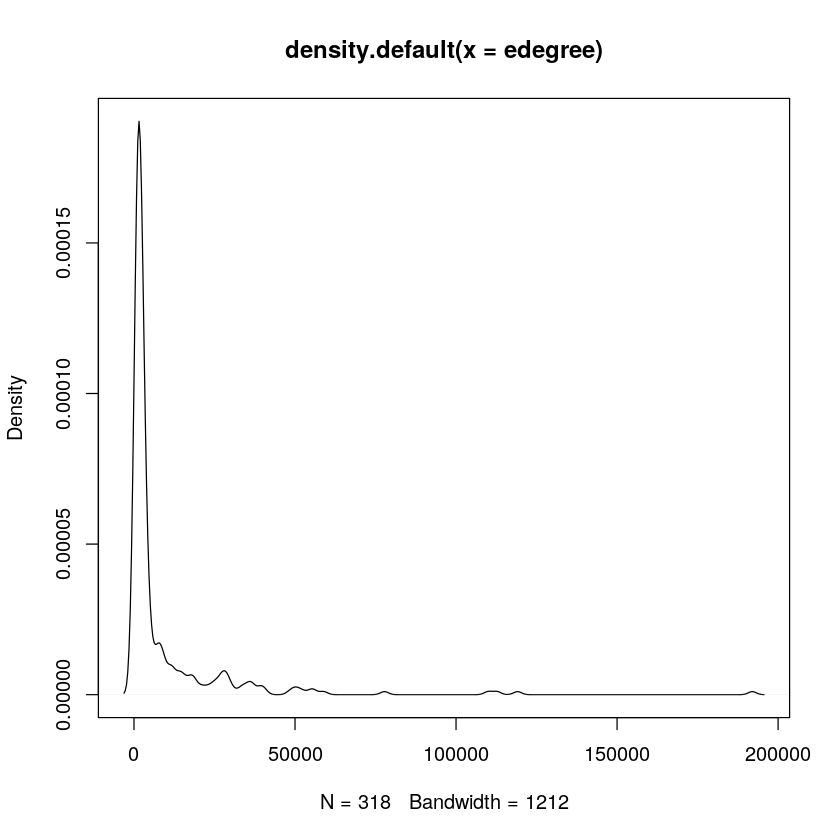

In [8]:
# plot the degree distribution for elites

# sum the columns for elites
edegree <- as.matrix(colSums(y))
# plot the distribution
plot(density(edegree))

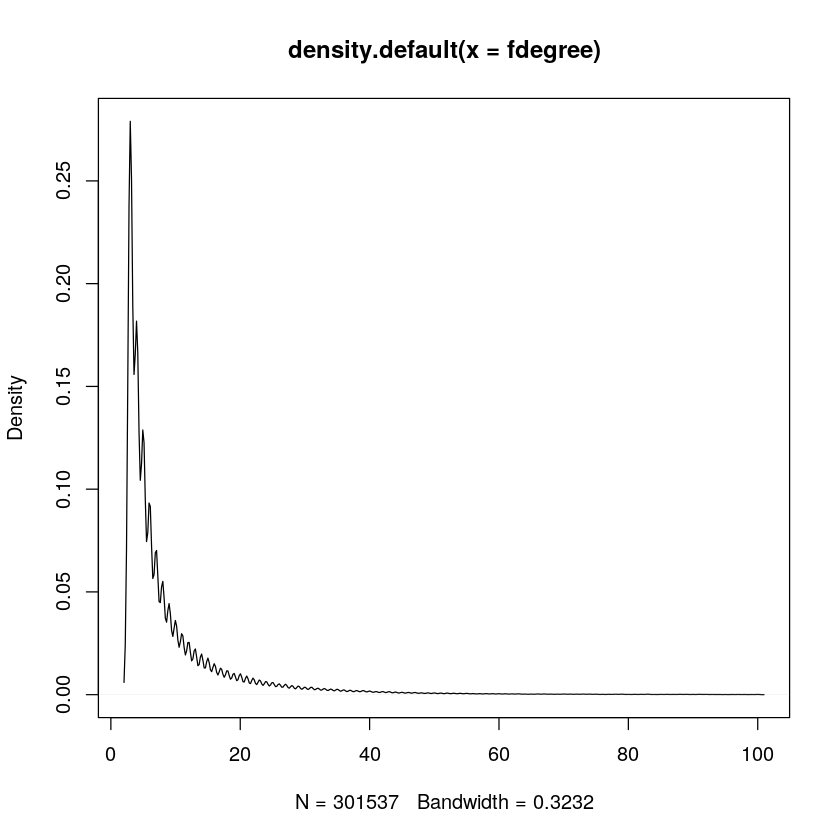

In [7]:
# sum the columns for followers
fdegree <- as.matrix(rowSums(y))
# plot the distribution
plot(density(fdegree))

In [67]:
fit_power_law(edegree)

$continuous
[1] FALSE

$alpha
[1] 1.701113

$xmin
[1] 846

$logLik
[1] -2789.346

$KS.stat
[1] 0.05297508

$KS.p
[1] 0.3834277

## Popularity retweet

In [21]:
g_retweet <- graph_from_edgelist(as.matrix(retweets[,c(2,3)]))

In [22]:
d_retweet <- degree(g_retweet)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



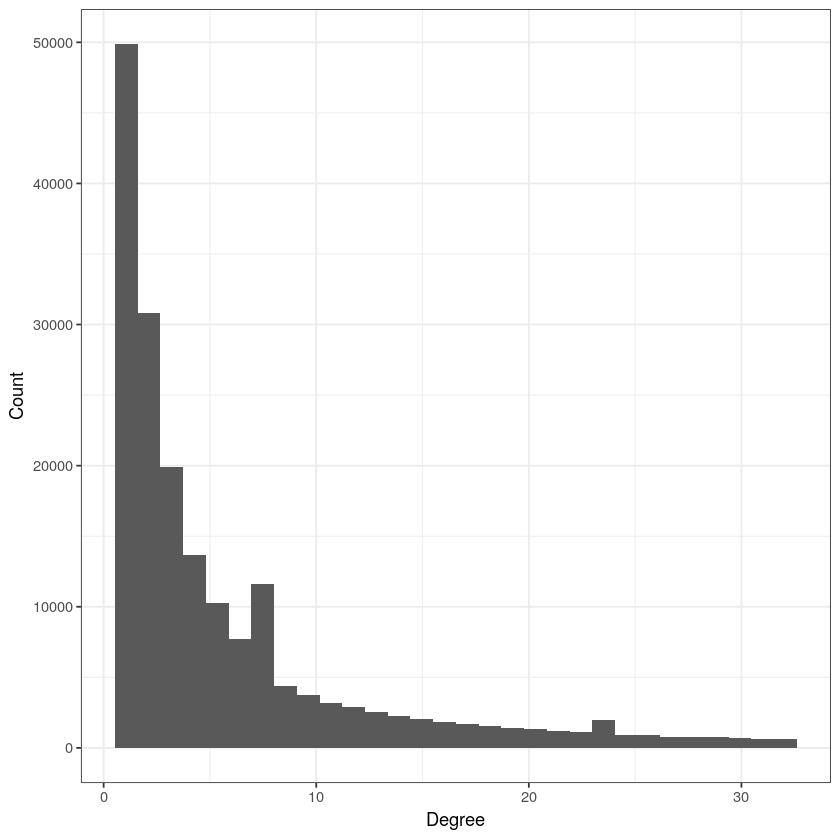

In [54]:
d_hist <- ggplot(as.data.frame(d_noout), aes(x=d_noout)) + 
    geom_histogram() +
    labs(x='Degree', y='Count') +
    theme_bw()

d_hist

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



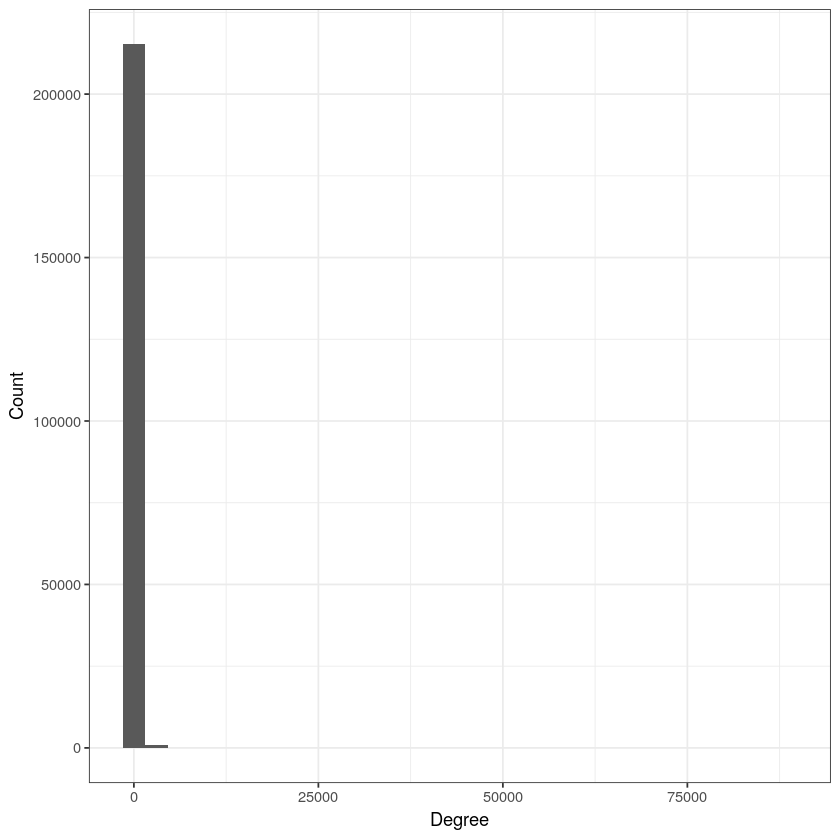

In [52]:
d_histout <- ggplot(as.data.frame(d_retweet), aes(x=d_retweet)) + 
    geom_histogram() +
    labs(x='Degree', y='Count') +
    theme_bw()

d_histout

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



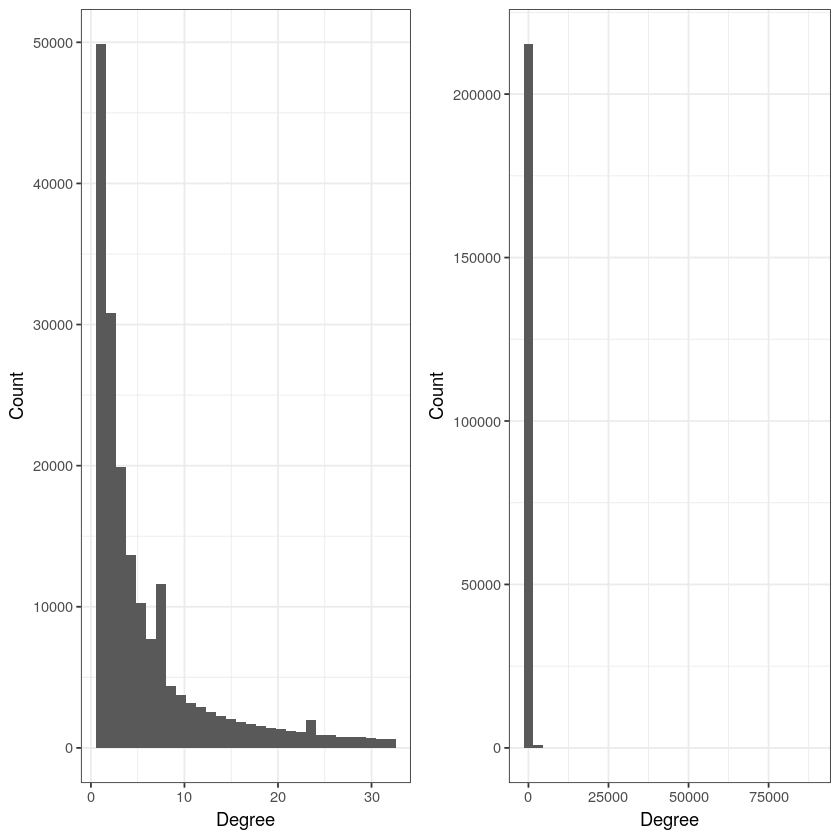

In [55]:
degree_grid <- grid.arrange(d_hist, 
                           d_histout, 
                           ncol = 2)

In [56]:
ggsave('degree.png', plot = degree_grid, width = 10, height = 5)

# attachment

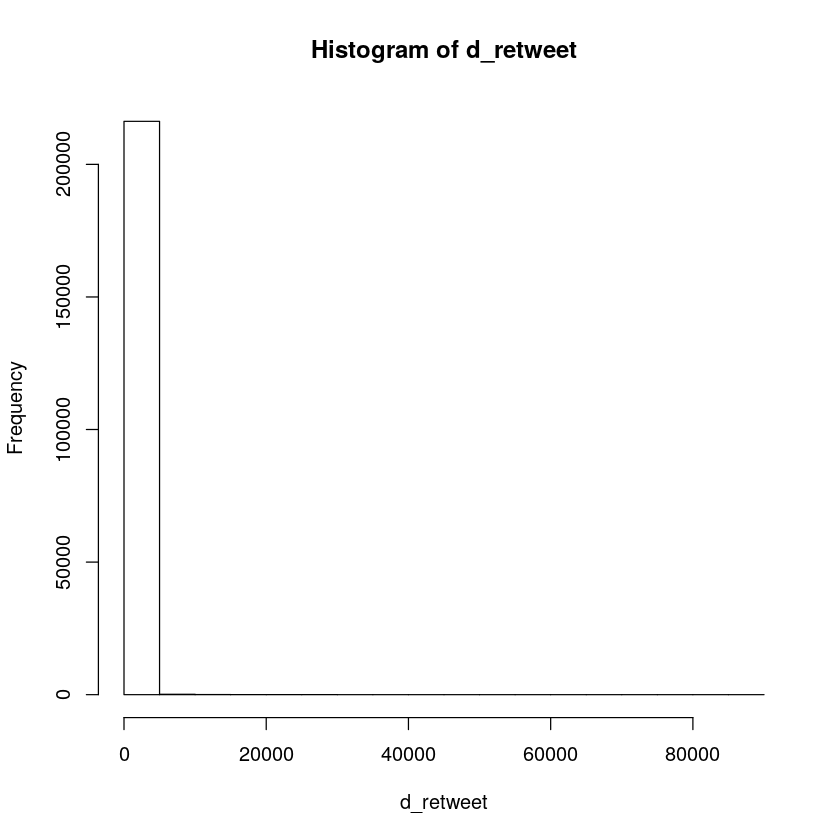

png 
  2

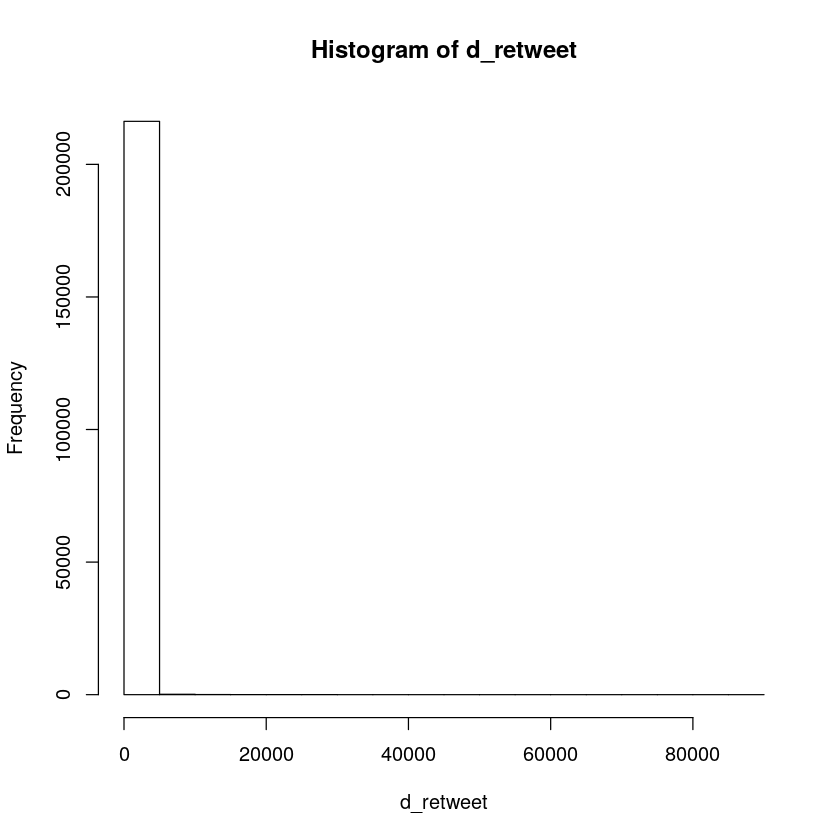

In [62]:
d_hist <- hist(d_retweet)
png('degree.png', width = 500, height = 500)
plot(1:length(d_hist$counts), d_hist$counts+1, xlab = "Degree", ylab = "Frequency", cex.lab = 1.5, main = "Scale-Free (log-log scale)", log = "xy", type = "b")
dev.off()

In [ ]:
png()

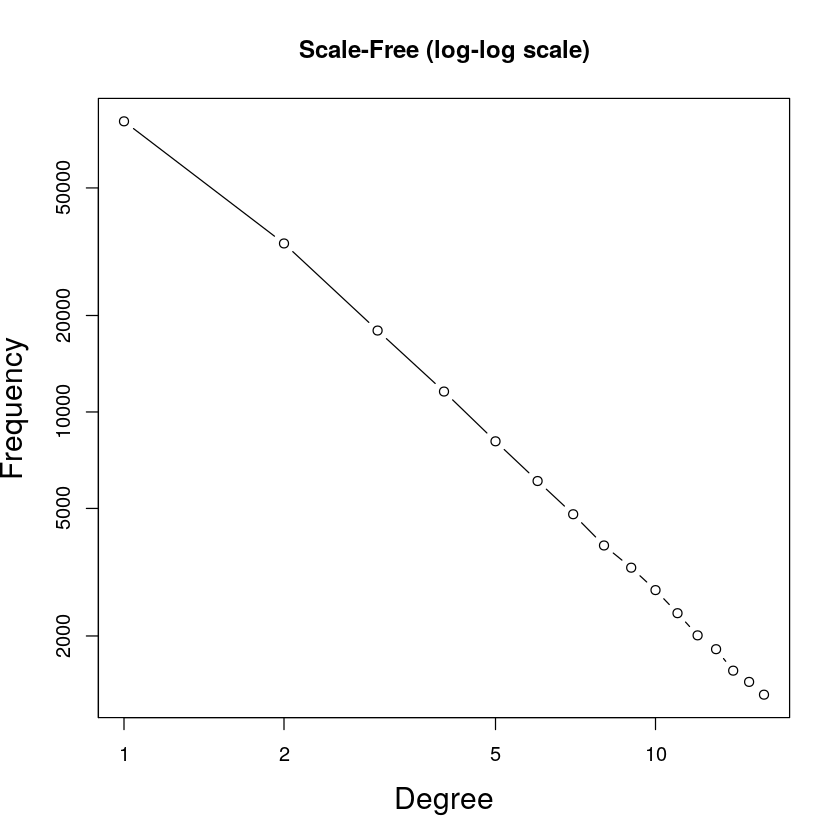

In [83]:
plot(1:length(noout_hist$counts), noout_hist$counts+1, xlab = "Degree", ylab = "Frequency", cex.lab = 1.5, main = "Scale-Free (log-log scale)", log = "xy", type = "b")

In [66]:
# seems to follow preferential attachment
fit_power_law(d_retweet)

$continuous
[1] FALSE

$alpha
[1] 2.487881

$xmin
[1] 1434

$logLik
[1] -11446.73

$KS.stat
[1] 0.01664783

$KS.p
[1] 0.8515818

In [141]:
fit_power_law(degree(g))

$continuous
[1] FALSE

$alpha
[1] 2.490669

$xmin
[1] 1438

$logLik
[1] -11301.06

$KS.stat
[1] 0.01641566

$KS.p
[1] 0.8681149

In [79]:
# when you drop outliers it no long follows preferential attachment
fit_power_law(d_noout)

$continuous
[1] FALSE

$alpha
[1] 1.964872

$xmin
[1] 3

$logLik
[1] -308565.7

$KS.stat
[1] 0.1005658

$KS.p
[1] 0

## Assortativity

1. add vertex attributes
2. get assortativity coefficient

In [6]:
# get a list of all vertex names in the original edge list
edgeids <- V(g_retweet)$name
# identify nodes in the retweet edge list that don't have a point estimate
missing <- edgeids[-which(edgeids %in% nodes$uid)]
# remove nodes with no point estimate
g_retweet <- delete_vertices(g_retweet, missing)
# create a new edge list
retweets_clean <- as_data_frame(g_retweet, what = 'edges')

# create a new graph object from clean edge list and node list
g <- graph_from_data_frame(retweets_clean, directed = TRUE, vertices = nodes)

ERROR: Error in "igraph" %in% class(graph): object 'g_retweet' not found


In [51]:
# check for preferential attachment in the new network
fit_power_law(degree(g))

$continuous
[1] FALSE

$alpha
[1] 2.490669

$xmin
[1] 1438

$logLik
[1] -11301.06

$KS.stat
[1] 0.01641566

$KS.p
[1] 0.8681149

In [20]:
# get the assortativity coeff
assortativity(g, types1 = V(g)$ideal_point)

[1] 0.7462079

## Transitivity

In [158]:
transitivity(g, 'global')

[1] 0.04747556

In [159]:
transitivity(g, 'local')

[1] 0.000000e+00 1.333333e-01 0.000000e+00          NaN 0.000000e+00
    [6] 0.000000e+00 8.381375e-02          NaN          NaN 1.338217e-01
   [11]          NaN          NaN 1.831731e-01 9.090909e-02          NaN
   [16] 6.617647e-02 0.000000e+00          NaN 0.000000e+00 6.666667e-02
   [21]          NaN          NaN          NaN 1.000000e-01          NaN
   [26]          NaN          NaN          NaN 0.000000e+00          NaN
   [31]          NaN 1.333333e-01          NaN 0.000000e+00 3.346902e-02
   [36] 3.208556e-02          NaN          NaN 0.000000e+00 0.000000e+00
   [41]          NaN 3.333333e-01 5.000000e-01 1.785384e-01          NaN
   [46] 0.000000e+00          NaN 2.852416e-02 1.634394e-01          NaN
   [51] 1.555556e-01 2.121212e-01          NaN 1.394917e-02 1.000000e+00
   [56]          NaN 2.222222e-01          NaN          NaN 6.060606e-02
   [61] 0.000000e+00          NaN          NaN          NaN          NaN
   [66]          NaN 9.629045e-02 1.985294e-01 0.000000e+00          NaN
   [71] 1.516449e-01 9.523810e-02          NaN          NaN          NaN
   [76]          NaN 0.000000e+00          NaN 9.569322e-02          NaN
   [81]          NaN          NaN 1.000000e-01          NaN 4.615385e-02
   [86] 0.000000e+00          NaN 7.142857e-02          NaN          NaN
   [91] 0.000000e+00 3.333333e-01          NaN 4.000000e-01 2.240896e-03
   [96]          NaN 0.000000e+00          NaN          NaN 1.000000e+00
  [101] 3.333333e-01 0.000000e+00          NaN 8.306922e-02          NaN
  [106]          NaN          NaN 1.077666e-02 1.272727e-01          NaN
  [111]          NaN          NaN          NaN 0.000000e+00          NaN
  [116]          NaN 0.000000e+00          NaN          NaN          NaN
  [121]          NaN 3.214286e-01 0.000000e+00          NaN 0.000000e+00
  [126] 4.934313e-02 1.038961e-01 5.555556e-02 3.555556e-01          NaN
  [131]          NaN 1.333333e-01          NaN 1.666667e-01          NaN
  [136] 0.000000e+00 1.272727e-01 4.756871e-02 1.000000e-01          NaN
  [141]          NaN          NaN 1.040293e-01          NaN 0.000000e+00
  [146]          NaN 2.380952e-01 0.000000e+00 0.000000e+00          NaN
  [151] 0.000000e+00 1.000000e+00 1.000000e-01 3.333333e-01 5.966724e-02
  [156] 1.321353e-01 0.000000e+00          NaN 0.000000e+00 0.000000e+00
  [161] 4.743083e-02 6.666667e-02 0.000000e+00          NaN 1.000000e-01
  [166] 0.000000e+00          NaN 3.286271e-02 1.825397e-01 0.000000e+00
  [171] 0.000000e+00          NaN 1.666667e-01          NaN          NaN
  [176] 0.000000e+00          NaN 1.111111e-01          NaN          NaN
  [181]          NaN          NaN 1.165577e-01 0.000000e+00 0.000000e+00
  [186] 0.000000e+00 0.000000e+00 0.000000e+00 1.000000e+00          NaN
  [191] 4.545455e-02 0.000000e+00          NaN          NaN          NaN
  [196] 2.415459e-01          NaN 2.272727e-01          NaN          NaN
  [201] 0.000000e+00 1.250000e-01 3.333333e-02 4.761905e-02          NaN
  [206] 0.000000e+00 2.222222e-02 0.000000e+00          NaN 8.333333e-02
  [211] 0.000000e+00 1.000000e-01          NaN          NaN          NaN
  [216]          NaN 0.000000e+00 7.142857e-02          NaN 0.000000e+00
  [221] 0.000000e+00 1.333333e-01 0.000000e+00          NaN          NaN
  [226] 2.777778e-02          NaN          NaN 0.000000e+00 4.761905e-02
  [231] 1.530317e-01          NaN          NaN 0.000000e+00 6.666667e-02
  [236]          NaN 1.000000e+00          NaN 1.306991e-01 1.000000e+00
  [241] 0.000000e+00 1.272727e-01 4.642857e-01          NaN 0.000000e+00
  [246] 0.000000e+00          NaN          NaN 1.774892e-01          NaN
  [251]          NaN 6.666667e-01 1.000000e+00          NaN          NaN
  [256] 0.000000e+00 0.000000e+00          NaN 1.666667e-01 1.282051e-02
  [261]          NaN          NaN 4.166667e-01 1.025641e-01 6.000000e-01
  [266]          NaN 5.769231e-02 1.000000e-01 1.111111e-01 0.000000e+00
  [271]          NaN          NaN 0.000000e+00 0.000000e+00 2.

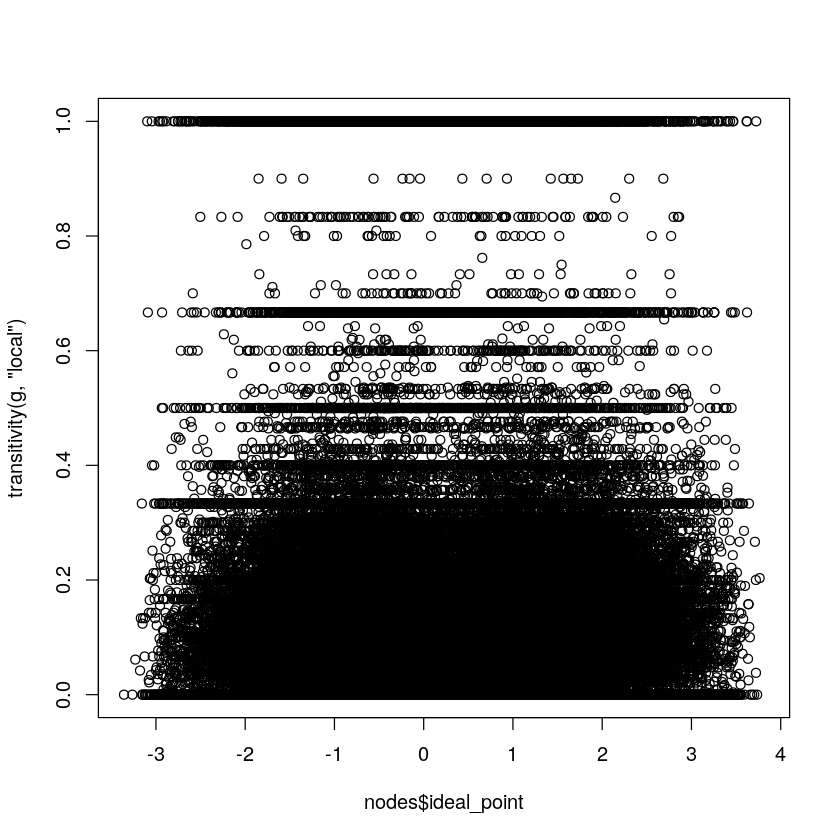

In [52]:
# plot transitivity by ideal point
plot(nodes$ideal_point, transitivity(g, 'local'))

# Recpiprocity

In [3]:
# clean up the nodes pipeline:

# create a graph from the edge list
g <- graph_from_edgelist(as.matrix(retweets[,c(2,3)]))
# get a list of all vertex names in the original edge list
edgeids <- V(g)$name

# get a list of all vertex names in the elites and followers data
# elites data
elites <- results[,c(1,2)]
colnames(elites) <- c('uid', 'ideal_point')
# followers data
followers <- users[,c('uid', 'theta')]
colnames(followers) <- c('uid', 'ideal_point')
# combine elites and followers data
nodes <- rbind(followers, elites)

# remove vertices with no point estimates from the data
# identify nodes in the retweet edge list that don't have a point estimate
missing <- edgeids[-which(edgeids %in% nodes$uid)]
# remove nodes from the network with no point estimate
g <- delete_vertices(g, missing)
# create a new edge list after dropping vertices
retweets_clean <- igraph::as_data_frame(g, what = 'edges')

# add meta data to the node list
# count number of times a node retweeted someone else
retweet_count <- count(retweets_clean, from)
colnames(retweet_count) <- c('uid', 'retweets')
# count the number of times a node was retweeted
retweeted_count <- count(retweets_clean, to)
colnames(retweeted_count) <- c('uid', 'retweeted')
# left join retweets with node list
nodes <- left_join(nodes, retweet_count, by = 'uid')
# left join retweeted with node list
nodes <- left_join(nodes, retweeted_count, by = 'uid')
# fill NA with zero 
nodes$retweets[is.na(nodes$retweets)] <- 0
nodes$retweeted[is.na(nodes$retweeted)] <- 0

# add reciprocity
# create retweet adjacency matrix
retweet_adj <- as_adj(g, edges=TRUE, sparse = TRUE)
# convert from numeric to binary sparse matrix
retweet_adj <- as(retweet_adj, "ngCMatrix")
# multiply the matrix aby its inverse and sum the rows to get the number of reciprocated ties
recip <- as.matrix(rowSums(retweet_adj*t(retweet_adj)))
# convert to df for joining
recip <- as.data.frame(recip)
recip$uid <- rownames(recip)
colnames(recip) <- c('reciprocity', 'uid')
# join to node list
nodes <- left_join(nodes, recip, by = 'uid')
# replace NA with 0
nodes$reciprocity[is.na(nodes$reciprocity)] <- 0

# create a new graph object from clean edge list and node list
g <- graph_from_data_frame(retweets_clean, directed = TRUE, vertices = nodes)

In [4]:
reciprocity(g)

[1] 0.03348786

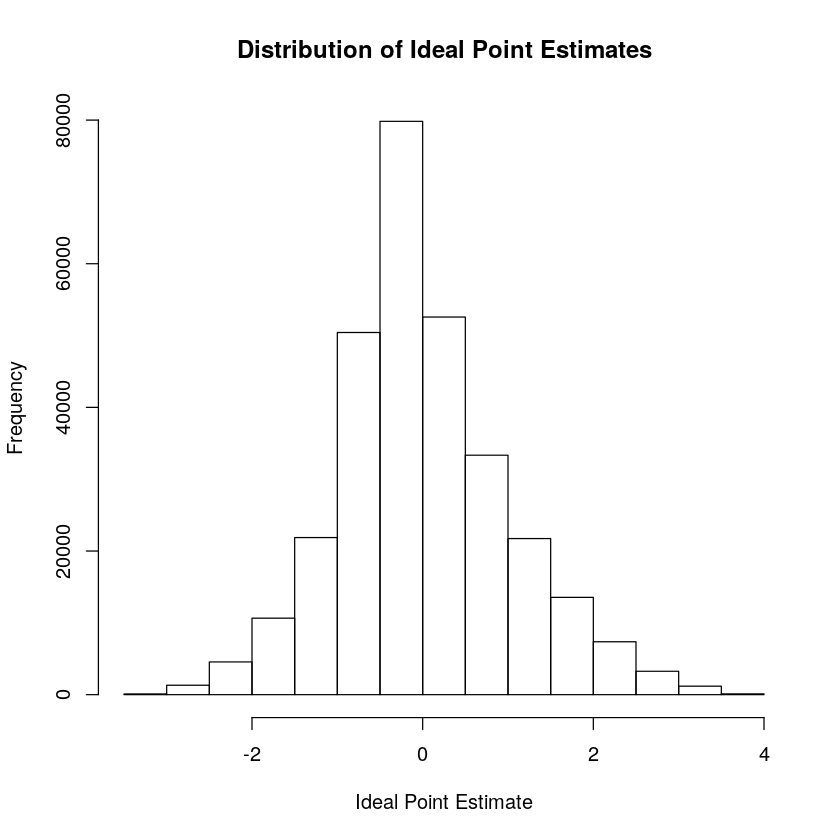

In [17]:
ideal_hist <- hist(nodes$ideal_point, 
                  xlab = 'Ideal Point Estimate',
                  main = 'Distribution of Ideal Point Estimates')

In [13]:
recip_scatter <- ggplot(nodes, aes(x=ideal_point, y=reciprocity)) +
    geom_point(shape=1) +
    labs(x='Ideal Point', y='Reciprocity') +
    theme_bw()

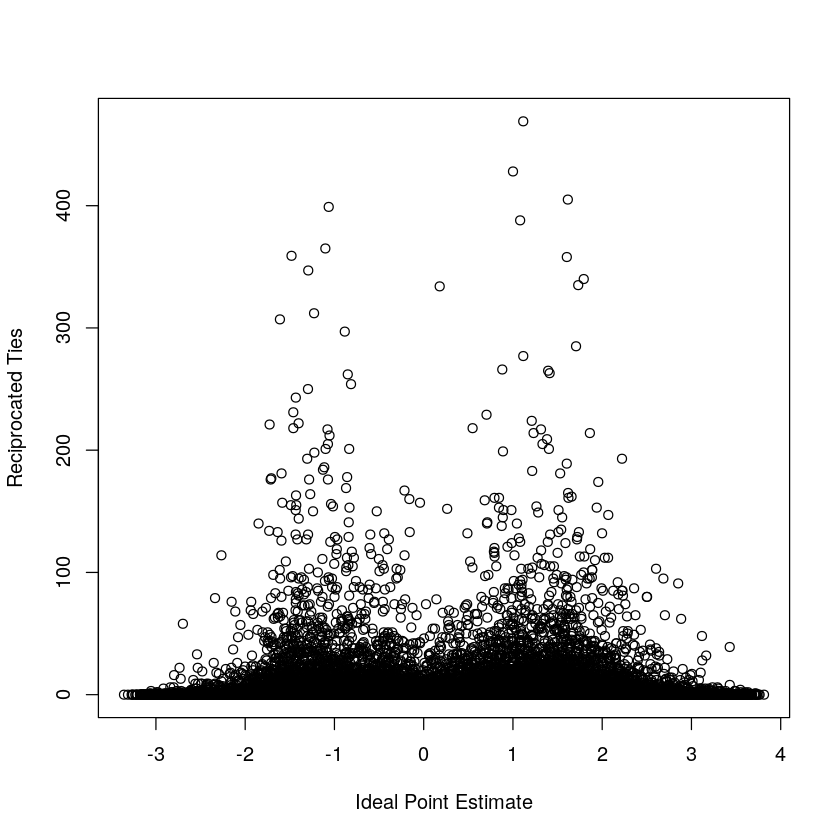

In [27]:
# reciprocity distribution by ideal point
recip_scatter <- plot(nodes$ideal_point, nodes$reciprocity, 
                      xlab = 'Ideal Point Estimate', 
                      ylab = 'Reciprocated Ties')

In [14]:
retweet_scatter <- ggplot(nodes, aes(x=ideal_point, y=retweets)) +
    geom_point(shape=1) +
    labs(x='Ideal Point', y='Retweets') +
    theme_bw()

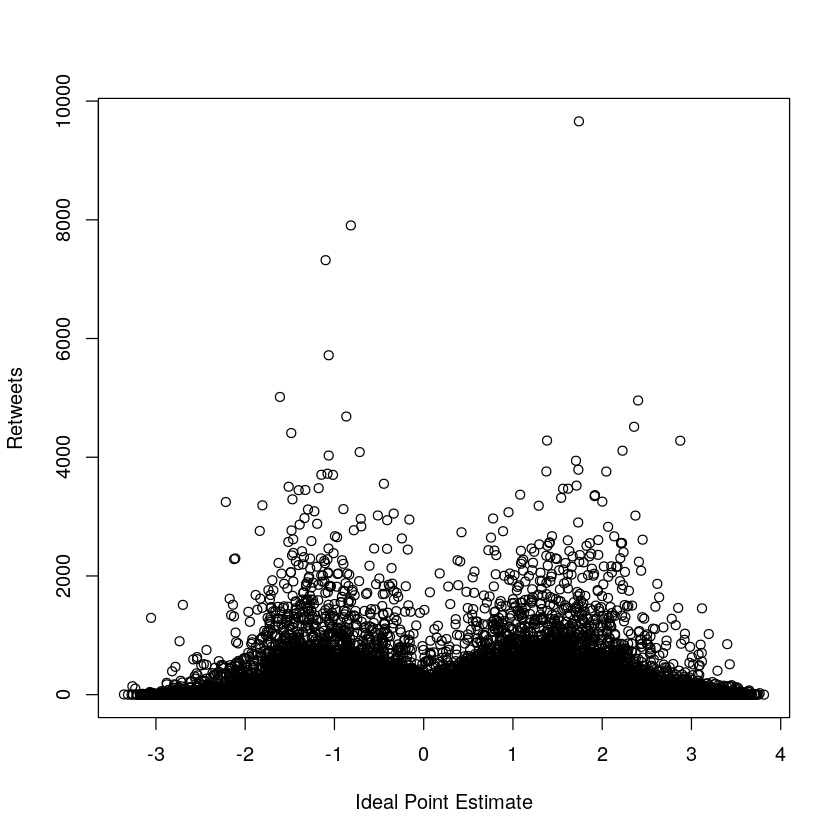

In [28]:
retweet_scatter <- plot(nodes$ideal_point, nodes$retweets,
                       xlab = 'Ideal Point Estimate',
                       ylab = 'Retweets')

In [15]:
retweeted_scatter <- ggplot(nodes, aes(x=ideal_point, y=retweeted)) +
    geom_point(shape=1) +
    labs(x='Ideal Point', y='Retweeted') +
    theme_bw()

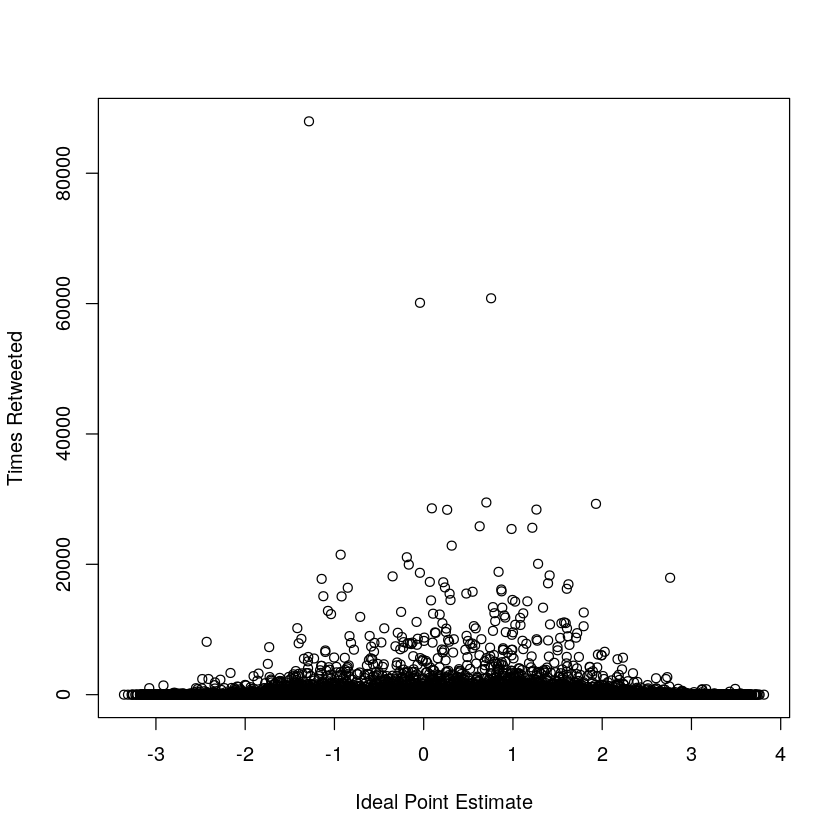

In [29]:
retweeted_scatter <- plot(nodes$ideal_point, nodes$retweeted,
                         xlab = 'Ideal Point Estimate',
                         ylab = 'Times Retweeted')

In [8]:
library(gridExtra)


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




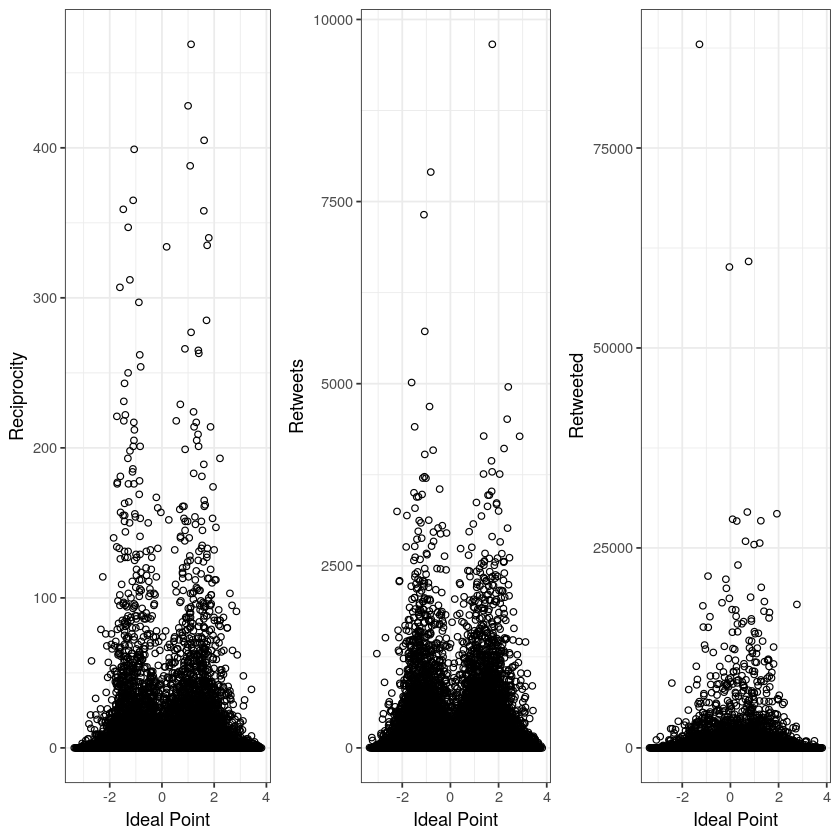

In [17]:
recip_grid <- grid.arrange(recip_scatter, 
                           retweet_scatter, 
                           retweeted_scatter, 
                           ncol = 3)

ggsave('reciprocity.png', plot = recip_grid, width = 15, height = 5)

In [ ]:
# add elite/follower tag
# add ideological group tag
# tag based on candidate mentioned in the tweet

# Show reciprocity by elite/user